# A Data-Driven Analysis of Anki Spaced Repetition

### <span style="color:green">**Importing**</span> the database:

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 15)

In [3]:
with open('ankipath.txt', 'r') as file:
    path_from_file = file.read().strip()

# Insert own path to Anki database, typically located in AppData/Roaming/Anki2/User 1/collection.anki2 (AppData is a hidden folder)
db_path = path_from_file

In [4]:
conn = sqlite3.connect(db_path)
# Get a cursor object using the connection
cursor = conn.cursor()

# This special SQL query will retrieve a list of all tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch all results from the executed query
tables = cursor.fetchall()

# Close the cursor
cursor.close()

for table in tables:
    print(table[0])

col
notes
cards
revlog
deck_config
config
fields
templates
notetypes
decks
sqlite_stat1
sqlite_stat4
tags
graves


In [5]:
query = "SELECT * FROM revlog;"
query_cards = "SELECT * FROM cards;"
df = pd.read_sql_query(query, conn)
df_cards = pd.read_sql_query(query_cards, conn)
conn.close()

### <span style="color:green">**Cleaning**</span> up df

In [6]:
df.head(5)

,id,cid,usn,ease,ivl,lastIvl,factor,time,type
0,1617599552375,1617263242211,54,1,-60,-60,0,12002,0
1,1617601745114,1617263242211,54,1,-60,-60,0,36995,0
2,1617601750108,1617263242212,54,3,-600,-60,0,4990,0
3,1617602240137,1617263242211,54,3,-600,-60,0,9051,0
4,1617602251363,1617263242213,54,3,-600,-60,0,11221,0


In [7]:
df.isnull().sum()

id         0
cid        0
usn        0
ease       0
ivl        0
lastIvl    0
factor     0
time       0
type       0
dtype: int64

Changing date to human format and adding hour of day column

In [8]:
review_time_temp = pd.to_datetime(df['id'], unit='ms', utc=True).dt.tz_convert('GMT')

df.insert(0, 'Review Time', review_time_temp)
df.insert(1, 'Hour of Day', df['Review Time'].dt.hour)

review_time_formatted = review_time_temp.dt.strftime('%Y-%m-%d %H:%M:%S') # converts to string
df['Review Time'] = review_time_formatted

df.head(5)

,Review Time,Hour of Day,id,cid,usn,ease,ivl,lastIvl,factor,time,type
0,2021-04-05 05:12:32,5,1617599552375,1617263242211,54,1,-60,-60,0,12002,0
1,2021-04-05 05:49:05,5,1617601745114,1617263242211,54,1,-60,-60,0,36995,0
2,2021-04-05 05:49:10,5,1617601750108,1617263242212,54,3,-600,-60,0,4990,0
3,2021-04-05 05:57:20,5,1617602240137,1617263242211,54,3,-600,-60,0,9051,0
4,2021-04-05 05:57:31,5,1617602251363,1617263242213,54,3,-600,-60,0,11221,0


Some of the review times date to 2021 but I started using the program in 2023, these review are probably anomalous so I will remove them. They only make up a fraction of the df so it shouldn't be too big of an issue

In [9]:
df.shape

(17121, 11)

In [10]:
df.loc[df['Review Time'].str[:4] == '2021']

,Review Time,Hour of Day,id,cid,usn,ease,ivl,lastIvl,factor,time,type
0,2021-04-05 05:12:32,5,1617599552375,1617263242211,54,1,-60,-60,0,12002,0
1,2021-04-05 05:49:05,5,1617601745114,1617263242211,54,1,-60,-60,0,36995,0
2,2021-04-05 05:49:10,5,1617601750108,1617263242212,54,3,-600,-60,0,4990,0
3,2021-04-05 05:57:20,5,1617602240137,1617263242211,54,3,-600,-60,0,9051,0
4,2021-04-05 05:57:31,5,1617602251363,1617263242213,54,3,-600,-60,0,11221,0
...,...,...,...,...,...,...,...,...,...,...,...
267,2021-04-16 05:33:16,5,1618551196139,1617263242266,54,3,-216000,-43200,0,2690,0
268,2021-04-16 05:33:26,5,1618551206997,1617263242264,54,3,-216000,-43200,0,10811,0
269,2021-04-16 05:34:05,5,1618551245353,1617263242249,54,3,-216000,-43200,0,38328,0
270,2021-04-16 05:34:16,5,1618551256629,1617263242261,54,3,-216000,-43200,0,11256,0


In [11]:
df.drop(df.loc[df['Review Time'].str[:4] == '2021'].index, inplace=True)

In [12]:
df.shape

(16849, 11)

Meaning of original column titles in df

- id: This is the timestamp of the review. It's stored as the number of milliseconds since the Unix epoch (January 1, 1970). You can convert this to a human-readable date and time.

- cid: This stands for 'card ID'. It is a unique identifier for the card that was reviewed. This ID can be used to link to the corresponding card in the cards table, which contains more details about the card itself.

- usn: This stands for 'update sequence number'. It's used for synchronizing with AnkiWeb. Whenever a change is made (like reviewing a card), the usn is incremented. It helps in keeping track of changes across different devices.

- ease: This column records how difficult you found the card during the review. In Anki, ease factors are typically 1 (again), 2 (hard), 3 (good), or 4 (easy).

- ivl: This stands for 'interval' and represents the number of days until the card is due again. It indicates the time interval before the next review of the card. Negative numbers can be used for cards in learning phases.

- lastIvl: This represents the interval in days since the last review of the card. Like ivl, negative numbers are used for cards in the learning phase.

- factor: This is the card's ease factor, which influences how quickly the intervals increase. It is used in the calculation of the next interval (ivl). The factor is in permille (parts per thousand), and it gets adjusted based on how you rate the card during reviews.

- time: This records the amount of time taken to answer the card, in milliseconds. It's a measure of the duration you spent on the review.

- type: This represents the type of review. The types can be new (0), learning (1), review (2), relearn (3), or filtered (4). This indicates the queue the card was in when it was reviewed.

In [13]:
df = df.drop(columns=['id', 'usn', 'factor'])
df = df.rename(columns={'ease': 'Card Ease', 'time': 'Time for Answer', 'cid': 'Card ID',
                         'ivl': 'Days to due', 'type': 'Review Type', 'lastIvl': 'Last Interval'})

df.set_index('Card ID', inplace=True)

df['Time for Answer'] = df['Time for Answer'] / 1000

In [14]:
df.head(5)

,Review Time,Hour of Day,Card Ease,Days to due,Last Interval,Time for Answer,Review Type
Card ID,,,,,,,
1339252520768,2023-10-02 00:09:51,0,4,5,0,56.667,0
1339252520769,2023-10-02 00:10:51,0,1,-60,0,59.960,0
1339252520770,2023-10-02 00:11:04,0,1,-60,0,12.646,0
1339252520771,2023-10-02 00:11:09,0,4,4,0,4.929,0
1339252520772,2023-10-02 00:11:38,0,1,-60,0,29.494,0


For cards that are new, unless they are known beforehand without anki, the response will always be 'Again', so I am discounting them from the calculations of time to answer and success rate

Card success value associates the card ease rating 1 (again), 2 (hard), 3 (good), 4 (easy) to a numerical counterpart with 0 being not known and 1 being known fluently. These will be subjective from person to person depending on how they use the answer buttons.

In [15]:
again, hard, good, easy = 0.2, 0.7, 0.9, 1
df['Card Success Value'] = df['Card Ease'].replace({1: again, 2: hard, 3: good, 4: easy})
df['Card Ease'] = df['Card Ease'].replace({1: 'Again', 2: 'Hard', 3: 'Good', 4: 'Easy'})
df.loc[df['Review Type'] == 0, ['Card Success Value', 'Time for Answer']] = np.nan

### <span style="color:orange">**Plotting**</span> Answer Time and Success Rate by Hour of the Day

In [16]:
avg_ans_time = df.groupby('Hour of Day')['Time for Answer'].mean()
avg_succ_rate = df.groupby('Hour of Day')['Card Success Value'].mean()

review_count_per_hour = df.groupby('Hour of Day')['Review Time'].count()
review_count_per_hour

Hour of Day
0     1291
1     2399
2     2557
3     1724
4      886
      ... 
19     772
20     647
21     373
22     295
23     546
Name: Review Time, Length: 21, dtype: int64

Removing hours of the day with review count too low to avoid anomolous results

In [17]:
threshold = 200
avg_ans_time[review_count_per_hour < threshold] = 0
avg_succ_rate[review_count_per_hour < threshold] = 0

hours_to_include = review_count_per_hour[review_count_per_hour >= threshold].index
ans_time_plot = avg_ans_time.loc[hours_to_include]
succ_plot = avg_succ_rate.loc[hours_to_include]
succ_plot = succ_plot * 100

These colors and styles will be used for all graphs by default

In [18]:
plt.style.use('default') # bmh doesn't change background color so this changes it to white
plt.style.use('bmh')
color1 = 'royalblue'
color2 = 'firebrick'

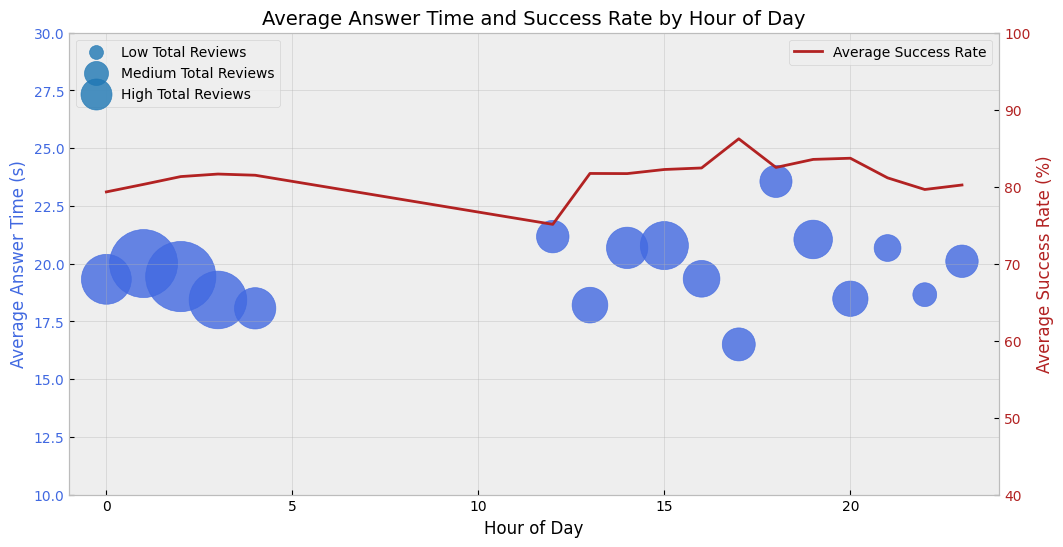

In [19]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Average answer time plot
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Average Answer Time (s)', color=color1)
ax1.scatter(ans_time_plot.index, ans_time_plot, s=review_count_per_hour.loc[hours_to_include], alpha=0.8, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim(-1, 24)
ax1.set_ylim(10, 30)

# Average success rate plot
ax2 = ax1.twinx()
ax2.set_ylabel('Average Success Rate (%)', color=color2)
ax2.plot(succ_plot.index, succ_plot, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(40, 100)

# Create a legend for the bubble sizes
bubble_sizes = [100, 300, 500]
bubble_labels = ['Low', 'Medium', 'High']
for size, label in zip(bubble_sizes, bubble_labels):
    ax1.scatter([], [], s=size, color='tab:blue', alpha=0.8, label=f'{label} Total Reviews')
legend1 = ax1.legend(loc='upper left', frameon=True)
legend2 = ax2.legend(['Average Success Rate'], loc='upper right', frameon=True)

ax1.set_title('Average Answer Time and Success Rate by Hour of Day', fontsize=14)
ax1.grid(True, linestyle='-', alpha=0.5)
ax2.grid(False)

plt.show()

The "Answer Time and Success Rate by Hour of Day" graph provides an intriguing look into how time of day might influence study habits and learning outcomes. Although no clear correlation emerges from this particular dataset, it hints at the complexity of learning dynamics and individual differences in cognitive performance throughout the day.

The graph shows fluctuations in success rate and answer time, which may suggest optimal and suboptimal periods for study due to variations in attention, fatigue, or other daily influences. This observation, while not directly contributing to the main findings, underscores the broader theme that effective learning is influenced by a multitude of factors, including the time of day when study sessions occur. Understanding these patterns can be valuable for personalizing the learning process, a key consideration highlighted in the project's conclusion.

### <span style="color:orange">**Plotting**</span> Answer Time and Success Rate by Last Interval

In [20]:
df.head(5)

,Review Time,Hour of Day,Card Ease,Days to due,Last Interval,Time for Answer,Review Type,Card Success Value
Card ID,,,,,,,,
1339252520768,2023-10-02 00:09:51,0,Easy,5,0,NaN,0,NaN
1339252520769,2023-10-02 00:10:51,0,Again,-60,0,NaN,0,NaN
1339252520770,2023-10-02 00:11:04,0,Again,-60,0,NaN,0,NaN
1339252520771,2023-10-02 00:11:09,0,Easy,4,0,NaN,0,NaN
1339252520772,2023-10-02 00:11:38,0,Again,-60,0,NaN,0,NaN


Need to remove instances when the last interval is negative as it will distort the graph, negative last intervals are used for unlearnt cards and don't apply here

In [21]:
df.loc[df['Last Interval'] < 1, 'Last Interval'] = np.nan

time_per_interval = df.groupby('Last Interval')['Time for Answer'].mean()
succ_per_interval = df.groupby('Last Interval')['Card Success Value'].mean()

succ_per_interval = succ_per_interval * 100

df.head(5)

,Review Time,Hour of Day,Card Ease,Days to due,Last Interval,Time for Answer,Review Type,Card Success Value
Card ID,,,,,,,,
1339252520768,2023-10-02 00:09:51,0,Easy,5,NaN,NaN,0,NaN
1339252520769,2023-10-02 00:10:51,0,Again,-60,NaN,NaN,0,NaN
1339252520770,2023-10-02 00:11:04,0,Again,-60,NaN,NaN,0,NaN
1339252520771,2023-10-02 00:11:09,0,Easy,4,NaN,NaN,0,NaN
1339252520772,2023-10-02 00:11:38,0,Again,-60,NaN,NaN,0,NaN


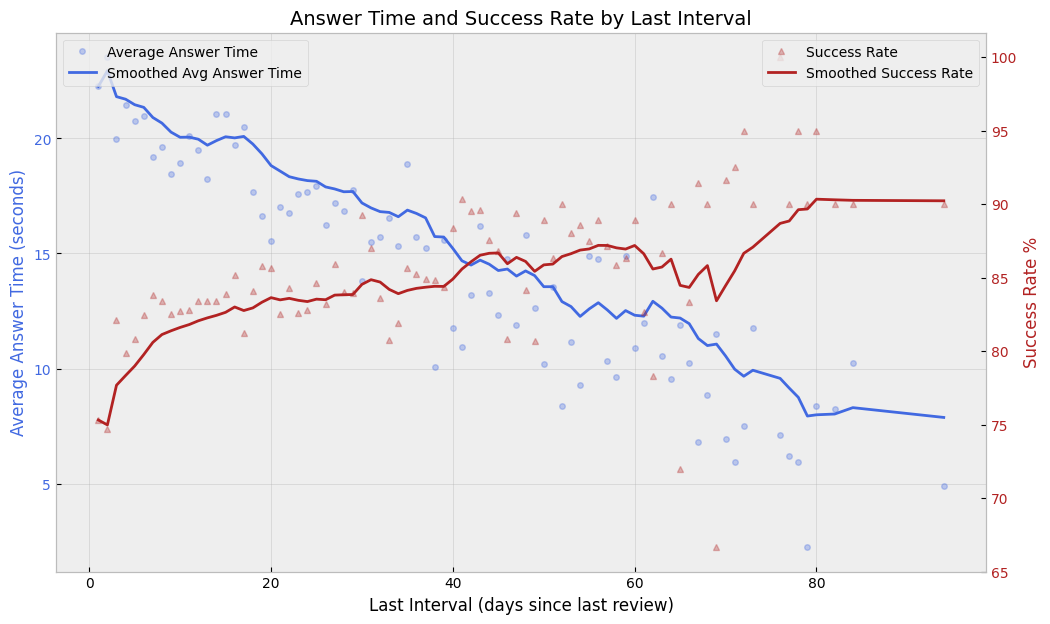

In [22]:
# Calculate Exponential Moving Averages
time_per_interval_smooth = time_per_interval.ewm(span=15).mean()
succ_per_interval_smooth = succ_per_interval.ewm(span=15).mean()

# Create a new plot with improved display
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot the average answer
# color1 = 'indigo'
ax1.plot(time_per_interval.index, time_per_interval, 'o', color=color1, markersize=4, alpha=0.3, label='Average Answer Time')
ax1.set_xlabel('Last Interval (days since last review)')
ax1.set_ylabel('Average Answer Time (seconds)', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, linestyle='--', alpha=0.5)

# Plot the success rate
ax2 = ax1.twinx()
# color2 = 'teal'
ax2.plot(succ_per_interval.index, succ_per_interval, '^', color=color2, markersize=4, alpha=0.3, label='Success Rate')
ax2.set_ylabel('Success Rate %', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Plot the smoothed moving averages
ax1.plot(time_per_interval_smooth.index, time_per_interval_smooth, color=color1, linestyle='-', linewidth=2, label='Smoothed Avg Answer Time')
ax2.plot(succ_per_interval_smooth.index, succ_per_interval_smooth, color=color2, linestyle='-', linewidth=2, label='Smoothed Success Rate')

# Title and legend improvements
ax1.set_title('Answer Time and Success Rate by Last Interval', fontsize=14)
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)
ax1.grid(True, linestyle='-', alpha=0.5)
ax2.grid(False)

plt.show()

The graph suggests that as study intervals increase, the time taken to answer decreases while the success rate improves. This indicates that over time, users are able to recall information more quickly and accurately, highlighting the effectiveness of spaced repetition for long-term retention. The data also shows variability in individual sessions, which is typical in learning scenarios.

There is a point of inflection in the Success Rate trend line, around the 30-40 interval range, where the rate of improvement in success appears to increase more sharply. This may represent a threshold beyond which the material is consolidated into long-term memory more efficiently.

### <span style="color:green">**Cleaning**</span> up df_cards and merging with df

Meaning of original columns in df_cards

id: The unique identifier for the card. It is typically the Unix timestamp of when the card was created.

nid: The note ID this card is associated with. Multiple cards can be generated from a single note, especially for note types that have multiple fields or cloze deletions.

did: The deck ID, indicating which deck the card belongs to.

ord: The ordinal, indicating the card's position within the note. For example, if a note generates three cards, their ord values would be 0, 1, and 2, respectively.

mod: The modification timestamp, indicating the last time the card was modified. This is also a Unix timestamp.

usn: The update sequence number used for synchronization. When you sync with AnkiWeb, the usn helps to determine which changes need to be merged.

type: The type of card. This can be new (0), learning (1), review (2), or relearning (3).

queue: The current queue status of the card. Similar to type, but includes more statuses like new (0), learning (1), review (2), day learning (3), preview (4), or suspended (-1).

due: The due date for review. For new cards, this is the card's position in the new card queue. For review cards, it is the Unix timestamp of the next review date.

ivl: The interval until the next review (in days). For new cards, this is typically zero.

factor: The ease factor of the card, which influences the growth of the interval. It starts at 2500 and goes up or down depending on how you rate the card during reviews.

reps: The number of times the card has been reviewed.

lapses: The number of times the card has lapsed (forgotten after being learned).

left: This is used during the learning phase and indicates how many more learning steps the card has left before it graduates to the review queue.

odue: If the card is in a filtered deck, this is the original due date before it was moved to the filtered deck.

odid: If the card is in a filtered deck, this is the original deck ID before it was moved to the filtered deck.

flags: User-defined flags on the card, which can be used to mark it for various purposes during reviews.

data: An additional field for storing miscellaneous data. Not used by Anki itself but can be utilized by add-ons or advanced users for custom information.

In [23]:
df_cards.head(5)

,id,nid,did,ord,mod,usn,type,queue,due,ivl,factor,reps,lapses,left,odue,odid,flags,data
0,1339252520768,1339252520768,1696205151172,0,1704844954,312,2,2,303,203,2800,5,0,0,0,0,0,"{""pos"":6000}"
1,1339252520769,1339252520769,1696205151172,0,1700365857,144,2,2,134,86,2950,13,0,0,0,0,0,"{""pos"":6001}"
2,1339252520770,1339252520770,1696205151172,0,1704471185,293,2,2,371,275,3100,7,0,0,0,0,0,"{""pos"":6002}"
3,1339252520771,1339252520771,1696205151172,0,1706934934,379,2,2,418,294,3100,6,0,0,0,0,0,"{""pos"":6003}"
4,1339252520772,1339252520772,1696205151172,0,1706752375,375,2,2,376,254,3100,14,0,0,0,0,0,"{""pos"":6004}"


In [24]:
df_cards.isnull().sum()

id       0
nid      0
did      0
ord      0
mod      0
        ..
left     0
odue     0
odid     0
flags    0
data     0
Length: 18, dtype: int64

In [25]:
df_cards.drop(columns=['did', 'mod', 'ord', 'usn', 'left', 'flags', 'odue', 'odid', 'data', 'queue', 'due', 'type', 'ivl'], inplace=True)

df_cards.rename(columns={'id': 'Card ID', 'nid': 'Note ID', 
                         'factor': 'Ease Factor', 'reps': 'Total Repetitions',
                         'lapses': 'Times Card Forgotten', 'left': 'Left'}, inplace=True)

df_cards.set_index('Card ID', inplace=True)

In [26]:
df_cards.head(5)

,Note ID,Ease Factor,Total Repetitions,Times Card Forgotten
Card ID,,,,
1339252520768,1339252520768,2800,5,0
1339252520769,1339252520769,2950,13,0
1339252520770,1339252520770,3100,7,0
1339252520771,1339252520771,3100,6,0
1339252520772,1339252520772,3100,14,0


In [27]:
df.head(5)

,Review Time,Hour of Day,Card Ease,Days to due,Last Interval,Time for Answer,Review Type,Card Success Value
Card ID,,,,,,,,
1339252520768,2023-10-02 00:09:51,0,Easy,5,NaN,NaN,0,NaN
1339252520769,2023-10-02 00:10:51,0,Again,-60,NaN,NaN,0,NaN
1339252520770,2023-10-02 00:11:04,0,Again,-60,NaN,NaN,0,NaN
1339252520771,2023-10-02 00:11:09,0,Easy,4,NaN,NaN,0,NaN
1339252520772,2023-10-02 00:11:38,0,Again,-60,NaN,NaN,0,NaN


In [28]:
df = df.merge(df_cards, on='Card ID', how='left')

Merging will allow me to analyse more correlations, could have done earlier in the notebook but makes no difference

In [29]:
df.sort_values(by='Card ID', inplace=True)
df.head(5)

,Review Time,Hour of Day,Card Ease,Days to due,Last Interval,Time for Answer,Review Type,Card Success Value,Note ID,Ease Factor,Total Repetitions,Times Card Forgotten
Card ID,,,,,,,,,,,,
1339252520768,2023-10-02 00:09:51,0,Easy,5,NaN,NaN,0,NaN,1.339253e+12,2800.0,5.0,0.0
1339252520768,2023-10-02 17:56:20,17,Easy,6,5.0,4.539,3,1.0,1.339253e+12,2800.0,5.0,0.0
1339252520768,2023-10-08 14:38:09,14,Easy,24,6.0,60.000,1,1.0,1.339253e+12,2800.0,5.0,0.0
1339252520768,2023-11-02 03:59:56,3,Good,69,24.0,3.999,1,0.9,1.339253e+12,2800.0,5.0,0.0
1339252520768,2024-01-10 00:02:34,0,Good,203,69.0,10.177,1,0.9,1.339253e+12,2800.0,5.0,0.0


### <span style="color:orange">**Plotting**</span> Time Taken for Answer Versus Success and Ease Factor

In [30]:
time_bins = range(0, int(df['Time for Answer'].max()) + 1)
df['Time Bin'] = pd.cut(df['Time for Answer'], bins=time_bins, include_lowest=True)

In [31]:
time_on_succ = df.groupby('Time Bin', observed=False)['Card Success Value'].mean()
time_on_succ = time_on_succ * 100
time_on_succ.index = time_on_succ.index.astype(str)

In [32]:
time_on_mat = df.groupby('Time Bin' , observed=False)['Ease Factor'].mean()
time_on_mat = time_on_mat / 10
time_on_mat.index = time_on_mat.index.astype(str)

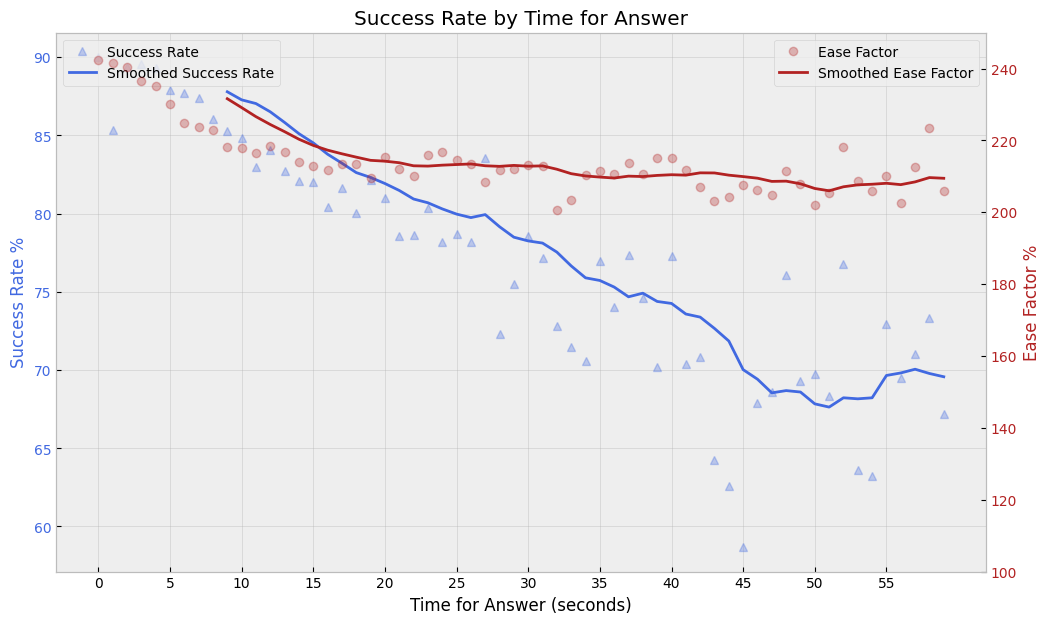

In [33]:
fig, ax = plt.subplots(figsize=(12, 7))

# color1 = 'olivedrab'
# color2 = 'dodgerblue'

# Plot the success rate
ax.plot(time_on_succ.index, time_on_succ, color=color1, marker='^', linestyle='', alpha=0.3, label='Success Rate')
ax.set_xlabel('Time for Answer (seconds)')
ax.set_ylabel('Success Rate %', color=color1)
ax.set_title('Success Rate by Time for Answer')

# Plot the ease factor
ax2 = ax.twinx()
ax2.plot(time_on_mat.index, time_on_mat, color=color2, marker='o', linestyle='', alpha=0.3, label='Ease Factor')
ax2.set_ylabel('Ease Factor %', color=color2)
ax2.set_ylim(100, 250)

# Set x-axis ticks
numeric_ticks = range(0, len(time_on_succ.index), 5)  # Adjust step as per actual data length if needed
ax.set_xticks(numeric_ticks)
ax.set_xticklabels(numeric_ticks)

# Enable grid
ax.grid(True, linestyle='-', alpha=0.5)
ax2.grid(False)

# Calculate rolling averages to smooth the data
time_on_succ_smooth = time_on_succ.rolling(window=10).mean()
time_on_mat_smooth = time_on_mat.rolling(window=10).mean()

# Plot the smoothed data
ax.plot(time_on_succ_smooth.index, time_on_succ_smooth, color=color1, linestyle='-', linewidth=2, label='Smoothed Success Rate')
ax2.plot(time_on_mat_smooth.index, time_on_mat_smooth, color=color2, linestyle='-', linewidth=2, label='Smoothed Ease Factor')


ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.tick_params(axis='y', labelcolor=color1)
ax2.tick_params(axis='y', labelcolor=color2)

plt.show()

- **Stable Ease Factor:** The ease factor remains relatively high and consistent across different answer times, suggesting that the SRS algorithm maintains a constant perception of card difficulty despite variations in user response times.

- **Decreasing Success Rate:** There is a clear trend of decreasing success rate as the time taken for an answer increases, indicating that cards requiring longer response times are associated with lower recall success.

- **Increased Variability in Success Rate:** The spread of the success rate data points increases with longer answer times, showing that there is more variability in how users successfully recall information as the difficulty—or perceived difficulty—increases.

- **Potential Disconnect:** The stability of the ease factor alongside the decreasing and more variable success rate could point to a disconnect between the algorithm’s difficulty adjustments and actual user performance, highlighting an area for potential refinement in the SRS algorithm.

- This analysis provides insight into the relationship between response times and perceived difficulty, as well as the potential influence of user learning patterns on Anki flashcard performance.

### <span style="color:orange">**Plotting**</span> Card Ease over Time

In [34]:
df.head(5)

,Review Time,Hour of Day,Card Ease,Days to due,Last Interval,Time for Answer,Review Type,Card Success Value,Note ID,Ease Factor,Total Repetitions,Times Card Forgotten,Time Bin
Card ID,,,,,,,,,,,,,
1339252520768,2023-10-02 00:09:51,0,Easy,5,NaN,NaN,0,NaN,1.339253e+12,2800.0,5.0,0.0,NaN
1339252520768,2023-10-02 17:56:20,17,Easy,6,5.0,4.539,3,1.0,1.339253e+12,2800.0,5.0,0.0,"(4.0, 5.0]"
1339252520768,2023-10-08 14:38:09,14,Easy,24,6.0,60.000,1,1.0,1.339253e+12,2800.0,5.0,0.0,"(59.0, 60.0]"
1339252520768,2023-11-02 03:59:56,3,Good,69,24.0,3.999,1,0.9,1.339253e+12,2800.0,5.0,0.0,"(3.0, 4.0]"
1339252520768,2024-01-10 00:02:34,0,Good,203,69.0,10.177,1,0.9,1.339253e+12,2800.0,5.0,0.0,"(10.0, 11.0]"


In [35]:
df['Review Time in DT'] = pd.to_datetime(df['Review Time'])
start_date = df['Review Time in DT'].min()
df['Days After Start'] = (df['Review Time in DT'] - start_date).dt.days
df.head(5)

,Review Time,Hour of Day,Card Ease,Days to due,Last Interval,Time for Answer,Review Type,Card Success Value,Note ID,Ease Factor,Total Repetitions,Times Card Forgotten,Time Bin,Review Time in DT,Days After Start
Card ID,,,,,,,,,,,,,,,
1339252520768,2023-10-02 00:09:51,0,Easy,5,NaN,NaN,0,NaN,1.339253e+12,2800.0,5.0,0.0,NaN,2023-10-02 00:09:51,0
1339252520768,2023-10-02 17:56:20,17,Easy,6,5.0,4.539,3,1.0,1.339253e+12,2800.0,5.0,0.0,"(4.0, 5.0]",2023-10-02 17:56:20,0
1339252520768,2023-10-08 14:38:09,14,Easy,24,6.0,60.000,1,1.0,1.339253e+12,2800.0,5.0,0.0,"(59.0, 60.0]",2023-10-08 14:38:09,6
1339252520768,2023-11-02 03:59:56,3,Good,69,24.0,3.999,1,0.9,1.339253e+12,2800.0,5.0,0.0,"(3.0, 4.0]",2023-11-02 03:59:56,31
1339252520768,2024-01-10 00:02:34,0,Good,203,69.0,10.177,1,0.9,1.339253e+12,2800.0,5.0,0.0,"(10.0, 11.0]",2024-01-10 00:02:34,99


In [36]:
daily_success = df.groupby('Days After Start')['Card Success Value'].mean()
daily_success = daily_success * 100
daily_ans_time = df.groupby('Days After Start')['Time for Answer'].mean()

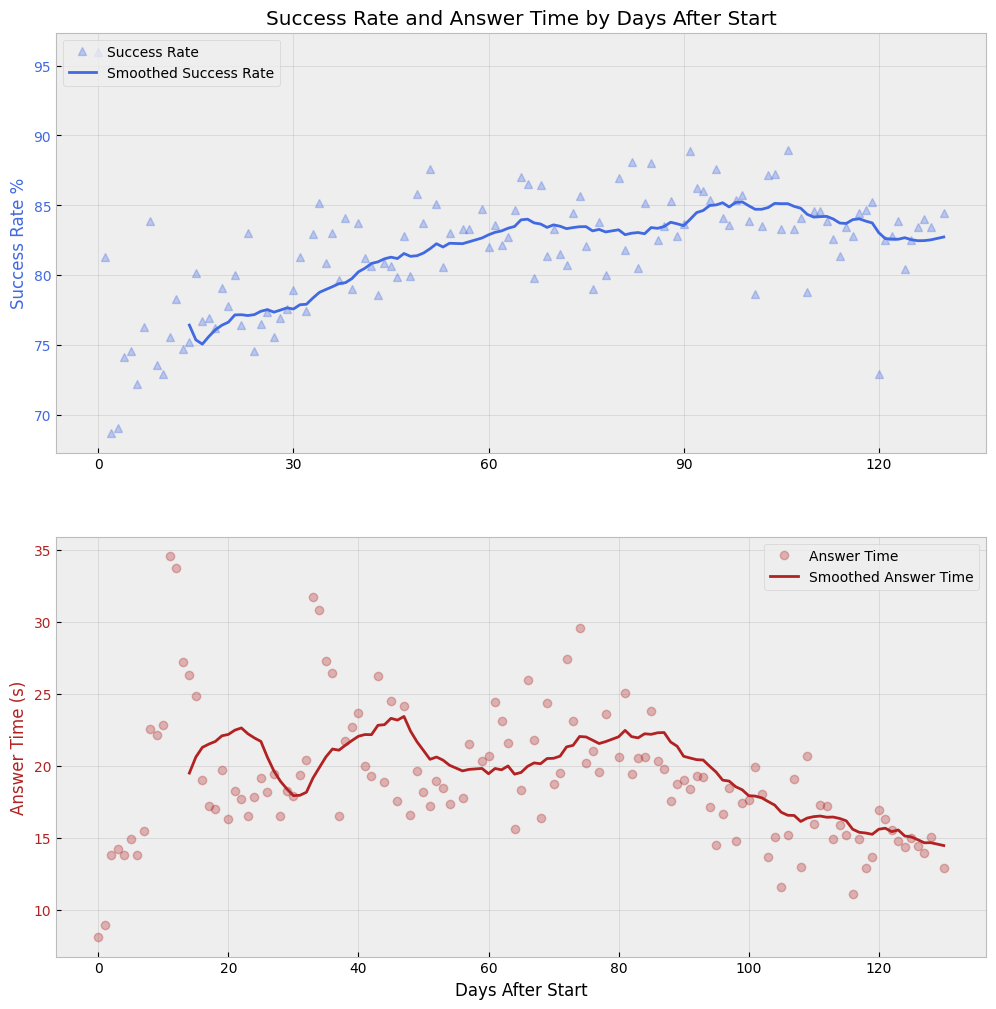

In [37]:
# plot succ rate days after starting anki and answer time on different graphs with linear regression

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=False)

# Plot the success rate
# color1 = 'darkorange'
ax1.plot(daily_success.index, daily_success, color=color1, marker='^', linestyle='', alpha=0.3, label='Success Rate')
ax1.set_ylabel('Success Rate %', color=color1)
ax1.set_title('Success Rate and Answer Time by Days After Start')

# Plot the answer time
# color2 = 'royalblue'
ax2.plot(daily_ans_time.index, daily_ans_time, color=color2, marker='o', linestyle='', alpha=0.3, label='Answer Time')
ax2.set_xlabel('Days After Start')
ax2.set_ylabel('Answer Time (s)', color=color2)

# Calculate rolling averages to smooth the data
daily_success_smooth = daily_success.rolling(window=15).mean()
daily_ans_time_smooth = daily_ans_time.rolling(window=15).mean()

# Plot the smoothed data
ax1.plot(daily_success_smooth.index, daily_success_smooth, color=color1, linestyle='-', linewidth=2, label='Smoothed Success Rate')
ax2.plot(daily_ans_time_smooth.index, daily_ans_time_smooth, color=color2, linestyle='-', linewidth=2, label='Smoothed Answer Time')

# Enable grid
ax1.grid(True, linestyle='-', alpha=0.5)
ax2.grid(True, linestyle='-', alpha=0.5)

# Set x-axis ticks
numeric_ticks = range(0, len(daily_success.index), 30)  # Adjust step as per actual data length if needed
ax1.set_xticks(numeric_ticks)
ax1.set_xticklabels(numeric_ticks)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.tick_params(axis='y', labelcolor=color1)
ax2.tick_params(axis='y', labelcolor=color2)

plt.show()


The graph indicates an overall improvement in Success Rate over time, suggesting enhanced recall ability with Anki usage. Average Answer Time remains fairly consistent, indicating stable recall speed. Day-to-day fluctuations are present in both metrics

### <span style="color:orange">**Plotting**</span> Total repetitions effect on Card Performance

In [38]:
repetitions_on_success = df.groupby('Total Repetitions')['Card Success Value'].mean()
repetitions_on_ans_time = df.groupby('Total Repetitions')['Time for Answer'].mean()

repetitions_on_success = repetitions_on_success * 100

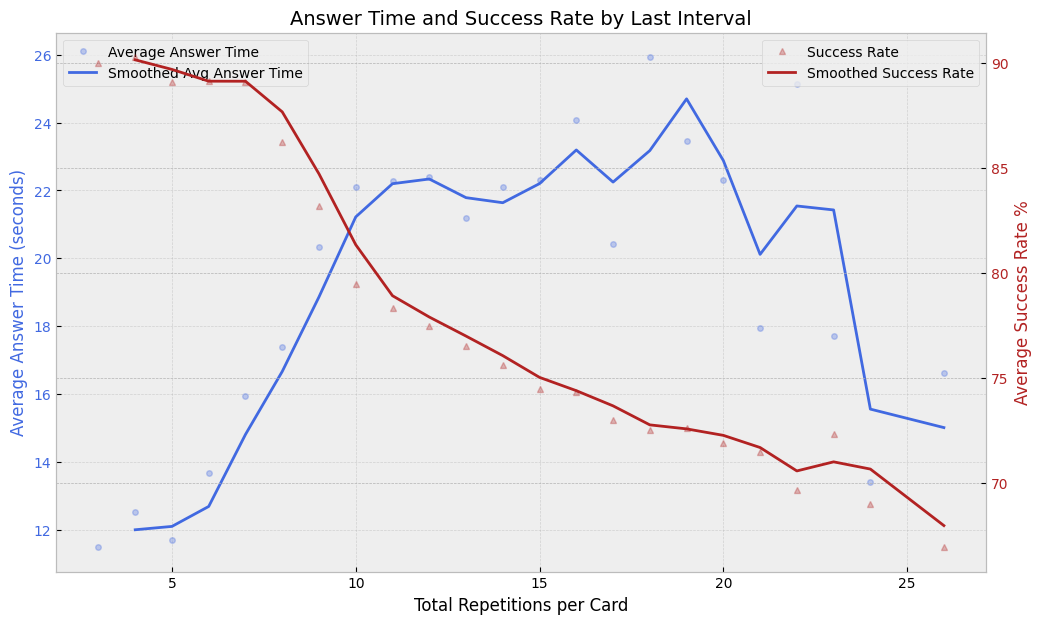

In [39]:
repetitions_on_success_smooth = repetitions_on_success.rolling(window=2).mean()
repetitions_on_ans_time_smooth = repetitions_on_ans_time.rolling(window=2).mean()

fig, ax1 = plt.subplots(figsize=(12, 7))

# color1 = 'darkorange'
ax1.plot(repetitions_on_ans_time.index, repetitions_on_ans_time, 'o', color=color1, markersize=4, alpha=0.3, label='Average Answer Time')
ax1.set_xlabel('Total Repetitions per Card')
ax1.set_ylabel('Average Answer Time (seconds)', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
# color2 = 'royalblue'
ax2.plot(repetitions_on_success.index, repetitions_on_success, '^', color=color2, markersize=4, alpha=0.3, label='Success Rate')
ax2.set_ylabel('Average Success Rate %', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

ax1.plot(repetitions_on_ans_time_smooth.index, repetitions_on_ans_time_smooth, color=color1, linestyle='-', linewidth=2, label='Smoothed Avg Answer Time')
ax2.plot(repetitions_on_success_smooth.index, repetitions_on_success_smooth, color=color2, linestyle='-', linewidth=2, label='Smoothed Success Rate')

ax1.set_title('Answer Time and Success Rate by Last Interval', fontsize=14)
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

plt.show()

This one is quite an interesting observation, this shows cards with higher total reps have a lower avg success rate, whereas our previous graph showed cards with higher interval times having a higher success rate

This could suggest cards are getting 'Stuck' on low interval distances, an unusual occurence where success rate decreases against review frequency

A brief Synopsis:

Challenges with low interval distances in SRS
In spaced repetition learning, the interval between reviews is crucial for effective memory consolidation. Ideally, as you progress, the intervals between reviews should increase, reflecting the transfer of information into long-term memory. However, a common challenge faced by learners is becoming "stuck" with low interval distances for certain flashcards, a phenomenon where the success rate declines despite frequent repetitions.

This "stuck" situation often arises with difficult material that isn't easily retained. It can be due to various factors, such as the complexity of the content, ineffective encoding, or insufficient context. When flashcards are reviewed frequently but without a corresponding increase in success rate, it indicates that the spaced repetition algorithm may not be optimally configured for these specific items.

Learners may need to adjust their study strategies for these "stuck" cards. Techniques might include breaking down complex information into smaller parts, creating more associative mnemonics, or applying the material in practical contexts. Additionally, it might be necessary to review these challenging flashcards outside the normal repetition cycle to provide extra reinforcement.

For the spaced repetition algorithm, it might be beneficial to introduce adaptive intervals that respond more sensitively to the learner's performance on individual cards, particularly those that are challenging. By doing so, the intervals can be more effectively calibrated to enhance retention and reduce the likelihood of cards becoming "stuck" at low intervals, facilitating a smoother learning journey and better long-term retention.

## **Conclusion:** A Comprehensive Analysis of Anki SRS Efficacy using Data

The collective insights from the dataset of Anki SRS reveal a multifaceted view of spaced repetition learning. **"Answer Time and Success Rate by Last Interval"** graph lays the foundational understanding that over time, as intervals between reviews increase, there is a corresponding increase in success rate and a decrease in answer time, showcasing the core benefit of spaced repetition in facilitating quicker and more accurate recall.

Conversely, the **"Success Rate by Time for Answer"** graph refines our perspective by revealing a negative correlation between the time taken to answer and the success rate. This indicates that although spaced repetition has its merits, the efficacy of recall is concurrently affected by the material's complexity and the learner's command of it. Interestingly, the graph also shows a relatively stable Ease Factor despite the declining success rate, which suggests that the SRS algorithm's adjustments to difficulty may not align with the learner's actual experiences. This constancy in the Ease Factor, alongside the variance in success rates, highlights the need for a more dynamic adjustment mechanism within Anki SRS to better tailor to individual learner differences and card difficulty levels.

Further longitudinal analysis provided by the **"Success Rate by Days After Starting Anki"** graph shows an overall improvement in success rates over time, reinforcing the notion that Anki's SRS improves recall abilities with continuous use. However, the consistent average answer time across the days suggests that recall speed reaches a point of stability, which might indicate a learning plateau or the progressive introduction of more complex material as the user advances.

The **"Answer Time and Success Rate by Total Repetitions per Card"** graph presents a significant anomaly in the expected behavior of spaced repetition systems. Here, an increased number of repetitions does not lead to an improved success rate, suggesting that some cards are not benefiting from the spaced repetition effect and are instead becoming "stuck" with low interval distances. This unexpected trend indicates that there are inefficiencies in the system, particularly in dealing with complex or challenging material that does not adhere to the typical pattern of memory retention facilitated by SRS.

Synthesizing the findings from these graphs, it becomes evident that Anki's SRS, while generally effective, exhibits variability in its efficacy. Such variability prompts consideration for refinement in both the SRS algorithm and user strategies. The algorithm might be improved by incorporating adaptive learning mechanisms that better accommodate individual learning trajectories and card difficulties. For users, augmenting Anki SRS with additional study techniques might be necessary to address the challenges posed by the "stuck" cards.

In conclusion, the Anki SRS stands as a potent tool for enhancing memory retention through spaced repetition. However, its one-size-fits-all approach is met with limitations when faced with the diverse nature of learner interactions and the complexity of information. An evolved, more adaptive SRS could lead to more personalized learning experiences, ensuring that the benefits of spaced repetition are fully realized across all spectrums of learning content.